In [5]:

# wrapper que integra Keras (TensorFlow) com Scikit-Learn para facilitar o uso de GridSearchCV - pois antes o KerasRegressor nao esta funcionando (from keras.wrappers.scikit_learn import KerasRegressor)
!pip install scikeras

# Acessar os valores das ações, petróleo (brent), ibovespa e minério de ferro
# !pip install yfinance

# Acessar a variável de entrada do fechamento do dólar
# !pip install python-bcb==0.3.3

# Foi preciso dar upgrade para rodar os imports
!pip install --upgrade scikit-learn

In [6]:
## 1. Importação de Bibliotecas

# Leitura, interpretação e plotar os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Normalização e avaliação do modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Construção do modelo LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Bases para as variáveis de entrada (features)
# import yfinance as yf
# from bcb import sgs

# Tempo de compilação, variáveis do sistema e aleatoriedade
import time
import os
import random

In [7]:
## 2. Criação de uma SEED

SEED = 0

def criar_seed(seed=SEED):
  os.environ['PYTHONHASHSEED'] = str(seed) # controla aleatoriedade interna do interpretador Python
  random.seed(seed) # controla aleatoriedade da biblioteca random
  np.random.seed(seed) # controla aleatoriedade do NumPy
  tf.random.set_seed(seed) # controla aleatoriedade do TensorFlow (pesos, embaralhamento, etc)

def setar_deterministico(seed=SEED): # garantir que se obtenha os mesmos valores ao rodar o código novamente
  criar_seed(seed=seed) # setar as seeds
  os.environ['TF_DETERMINISTIC_OPS'] = '1' # força o TensorFlow a usar operações determinísticas
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # força operações determinísticas específicas da GPU (cuDNN)
  tf.config.threading.set_inter_op_parallelism_threads(1) # limita o paralelismo entre operações a 1 thread
  tf.config.threading.set_intra_op_parallelism_threads(1) # limita o paralelismo dentro de cada operação a 1 thread

setar_deterministico(SEED)  # Executa tudo acima com a seed escolhida

In [8]:
## 3. Coleta dos Dados

# Tempo inicial de compilação
_start_time = time.time()

# Carregar os dados diretamente do CSV salvo localmente
df = pd.read_csv("/content/VALE3.SA.csv")

# Converter a coluna Date para datetime
df['Date'] = pd.to_datetime(df['Date'])

# Colocar a coluna Date como índice
df.set_index('Date', inplace=True)

# Visualizar o início do DataFrame
df.head()

,Close_VALE3.SA,High_VALE3.SA,Low_VALE3.SA,Open_VALE3.SA,Volume_VALE3.SA,Close_Dolar,Close_Petroleo,Close_Ibovespa,Close_Selic,Close_IPCA,Close_Minerio,Close_Energia,Close_Consumo
Date,,,,,,,,,,,,,
2016-01-04,7.045114,7.206113,6.928528,6.934080,4587900,3.9491,37.220001,42141.0,0.052531,1.27,13.606012,1.51,88.9
2016-01-05,6.950736,7.128390,6.889667,7.034011,2693500,4.0373,36.419998,42419.0,0.052531,1.27,13.720954,1.51,88.9
2016-01-06,6.439979,6.723115,6.434427,6.706460,6758900,4.0269,34.230000,41773.0,0.052531,1.27,12.945108,1.51,88.9
2016-01-07,6.056911,6.312289,6.040256,6.251220,6450400,4.0199,33.750000,40695.0,0.052531,1.27,12.360831,1.51,88.9
2016-01-08,5.851498,6.245669,5.851498,6.145738,4429400,4.0415,33.549999,40612.0,0.052531,1.27,12.006433,1.51,88.9


In [9]:
## 4. Preparação e Merge dos Dados

# Verificar se há valores ausentes
print("Valores ausentes por coluna:\n", df.isnull().sum())

# Remover valores nulos, se necessário
df.dropna(inplace=True)

# Visualizar novamente
df.head()

Valores ausentes por coluna:
 Close_VALE3.SA     0
High_VALE3.SA      0
Low_VALE3.SA       0
Open_VALE3.SA      0
Volume_VALE3.SA    0
Close_Dolar        0
Close_Petroleo     0
Close_Ibovespa     0
Close_Selic        0
Close_IPCA         0
Close_Minerio      2
Close_Energia      0
Close_Consumo      0
dtype: int64


,Close_VALE3.SA,High_VALE3.SA,Low_VALE3.SA,Open_VALE3.SA,Volume_VALE3.SA,Close_Dolar,Close_Petroleo,Close_Ibovespa,Close_Selic,Close_IPCA,Close_Minerio,Close_Energia,Close_Consumo
Date,,,,,,,,,,,,,
2016-01-04,7.045114,7.206113,6.928528,6.934080,4587900,3.9491,37.220001,42141.0,0.052531,1.27,13.606012,1.51,88.9
2016-01-05,6.950736,7.128390,6.889667,7.034011,2693500,4.0373,36.419998,42419.0,0.052531,1.27,13.720954,1.51,88.9
2016-01-06,6.439979,6.723115,6.434427,6.706460,6758900,4.0269,34.230000,41773.0,0.052531,1.27,12.945108,1.51,88.9
2016-01-07,6.056911,6.312289,6.040256,6.251220,6450400,4.0199,33.750000,40695.0,0.052531,1.27,12.360831,1.51,88.9
2016-01-08,5.851498,6.245669,5.851498,6.145738,4429400,4.0415,33.549999,40612.0,0.052531,1.27,12.006433,1.51,88.9


In [10]:
## 5. Normalização

scaler = MinMaxScaler() # usa o minmaxscaler como normalizador para escalar os dados entre 0 e 1
dados_escalados = scaler.fit_transform(df) # aplica o normalizador a todos os dados numéricos

In [11]:
## 6. Criação da Janela Deslizante (21 dias)

def createXY(dataset, n_past): # função que cria as janelas deslizantes
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)): # começa no n_past (=21)
        dataX.append(dataset[i - n_past:i, :]) # para cada ponto no tempo, pega os últimos 'n_past' dias como entrada (X)
        dataY.append(dataset[i, 0]) # a saída (y) será o valor de fechamento da VALE3 no dia seguinte; o índice 0 representa o Close_Vale3 que vai ser a variável de saída (predição)
    return np.array(dataX), np.array(dataY)

X, y = createXY(dados_escalados, 21) # gera os arrays X (entradas) e y (saídas) com uma janela de 21 dias

# Separar treino e teste (80/20)
split = int(len(X) * 0.8) # faz o corte de 80% dos dados
X_train, X_test = X[:split], X[split:] # train (treino) = 80% dos dados; test (teste) = 20% dos dados --> X
y_train, y_test = y[:split], y[split:] # train (treino) = 80% dos dados; test (teste) = 20% dos dados --> Y

In [12]:
## 7. Construção do Modelo com GridSearchCV (2ª arquitetura)

def build_model(optimizer='adam'): # função para criar o modelo LSTM como base para o GridSearchCV
    model = Sequential() # cria um modelo sequencial (camadas empilhadas)
    model.add(LSTM(32, return_sequences=True, input_shape=(15, X_train.shape[2]))) # primeira camada LSTM com 128 neurônios e retorno da sequência para a próxima LSTM
    # model.add(Dropout(0.3)) # dropout após a primeira LSTM (evita overfitting logo na entrada)
    model.add(LSTM(16)) # segunda camada LSTM com 64 neurônios (sem return_sequences, pois é a última LSTM)
    model.add(Dense(10)) # camada densa intermediária com 10 neurônios (pode ajudar a refinar a saída)
    model.add(Dense(1)) # camada de saída com 1 neurônio (regressão: previsão de um único valor)
    model.compile(optimizer=optimizer, loss='mse') # compila o modelo com o otimizador informado e função de erro MSE (erro quadrático médio)
    return model


model = KerasRegressor(model=build_model, verbose=1) # envolve o modelo Keras dentro de um wrapper compatível com scikit-learn (necessário para o GridSearchCV)

params = { # definição dos hiperparâmetros
    'batch_size': [14, 16, 20], # tamanhos de lote a testar
    'epochs': [70, 80, 90], # número de épocas de treino
    'optimizer': ['adam'] # otimizador usado na compilação
}

# 'RMSprop', 'Nadam', 'Adamax'

grid = GridSearchCV(estimator=model, param_grid=params, cv=4) # inicializa o GridSearchCV para encontrar os melhores hiperparâmetros usando validação cruzada (cv=3)
grid_result = grid.fit(X_train, y_train) # realiza o treinamento e busca dos melhores parâmetros

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.1336
Epoch 2/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0020
Epoch 3/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0015
Epoch 4/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0013
Epoch 5/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012
Epoch 6/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 7/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.7897e-04
Epoch 8/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.0618e-04
Epoch 9/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.4869e-04
Epoch 10/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.0231e-04
Epoch 11/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.6640e-04
Epoch 12/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.3931e-04
Epoch 13/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.1745e-04
Epoch 14/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.9861e-04
Epoch 15/70
97/97 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0360
Epoch 2/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 3/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0010
Epoch 4/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.1796e-04
Epoch 5/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.6135e-04
Epoch 6/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.1447e-04
Epoch 7/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.0196e-04
Epoch 8/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.1318e-04
Epoch 9/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 8.1567e-04
Epoch 10/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.0862e-04
Epoch 11/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.9723e-04
Epoch 12/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.8434e-04
Epoch 13/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.7125e-04
Epoch 14/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.5846e-04
Epoch 15/70
97/97 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0179
Epoch 2/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0014
Epoch 3/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012
Epoch 4/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.7902e-04
Epoch 5/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.8647e-04
Epoch 6/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.1372e-04
Epoch 7/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.6422e-04
Epoch 8/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7.2712e-04
Epoch 9/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.9748e-04
Epoch 10/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.7232e-04
Epoch 11/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.5007e-04
Epoch 12/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.2989e-04
Epoch 13/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1130e-04
Epoch 14/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.9398e-04
Epoch 15/70
97/97 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0380
Epoch 2/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7198e-04
Epoch 3/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 5.3552e-04
Epoch 4/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 5.2362e-04
Epoch 5/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.0905e-04
Epoch 6/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.8903e-04
Epoch 7/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.6532e-04
Epoch 8/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 4.4353e-04
Epoch 9/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.2448e-04
Epoch 10/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.0812e-04
Epoch 11/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.9422e-04
Epoch 12/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.8241e-04
Epoch 13/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.7229e-04
Epoch 14/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 3.6347e-04
Epoch 15/70
97/97 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0781
Epoch 2/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0017
Epoch 3/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0013
Epoch 4/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012
Epoch 5/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011
Epoch 6/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 7/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.5690e-04
Epoch 8/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.0502e-04
Epoch 9/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.6482e-04
Epoch 10/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.3370e-04
Epoch 11/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.0933e-04
Epoch 12/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.8913e-04
Epoch 13/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.7087e-04
Epoch 14/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 7.5316e-04
Epoch 15/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0433
Epoch 2/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 3/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0012
Epoch 4/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011
Epoch 5/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0010
Epoch 6/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0010
Epoch 7/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.9136e-04
Epoch 8/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9.6732e-04
Epoch 9/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.3389e-04
Epoch 10/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.0362e-04
Epoch 11/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.7589e-04
Epoch 12/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.5164e-04
Epoch 13/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.3068e-04
Epoch 14/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.1230e-04
Epoch 15/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0659
Epoch 2/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 3/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0010
Epoch 4/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.9660e-04
Epoch 5/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.2625e-04
Epoch 6/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.7665e-04
Epoch 7/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.3228e-04
Epoch 8/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.9088e-04
Epoch 9/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.5633e-04
Epoch 10/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 6.3208e-04
Epoch 11/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1359e-04
Epoch 12/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.9649e-04
Epoch 13/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.8057e-04
Epoch 14/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.6601e-04
Epoch 15/80
97/97 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0170
Epoch 2/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.0907e-04
Epoch 3/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.3076e-04
Epoch 4/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7428e-04
Epoch 5/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1680e-04
Epoch 6/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 4.7605e-04
Epoch 7/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.4652e-04
Epoch 8/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.2481e-04
Epoch 9/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.0798e-04
Epoch 10/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.9405e-04
Epoch 11/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.8200e-04
Epoch 12/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.7137e-04
Epoch 13/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.6195e-04
Epoch 14/80
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.5362e-04
Epoch 15/80
97/97 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1042
Epoch 2/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016
Epoch 3/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0012
Epoch 4/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 5/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.5092e-04
Epoch 6/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.9883e-04
Epoch 7/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.5862e-04
Epoch 8/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.2732e-04
Epoch 9/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.0203e-04
Epoch 10/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.8051e-04
Epoch 11/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.6151e-04
Epoch 12/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.4430e-04
Epoch 13/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.2845e-04
Epoch 14/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.1368e-04
Epoch 15/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0428
Epoch 2/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0014
Epoch 3/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0012
Epoch 4/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0010
Epoch 5/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0011
Epoch 6/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0010
Epoch 7/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.7059e-04
Epoch 8/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.3221e-04
Epoch 9/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.0041e-04
Epoch 10/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.7370e-04
Epoch 11/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.5080e-04
Epoch 12/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.3073e-04
Epoch 13/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.1275e-04
Epoch 14/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.9629e-04
Epoch 15/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0161
Epoch 2/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 3/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.8238e-04
Epoch 4/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.5891e-04
Epoch 5/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.9070e-04
Epoch 6/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.2849e-04
Epoch 7/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.7764e-04
Epoch 8/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.3516e-04
Epoch 9/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.9887e-04
Epoch 10/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.6742e-04
Epoch 11/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.4009e-04
Epoch 12/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.1637e-04
Epoch 13/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 5.9584e-04
Epoch 14/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7806e-04
Epoch 15/90
97/97 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0215
Epoch 2/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.7660e-04
Epoch 3/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.9640e-04
Epoch 4/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.4520e-04
Epoch 5/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 5.3018e-04
Epoch 6/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.0551e-04
Epoch 7/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.7571e-04
Epoch 8/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.4826e-04
Epoch 9/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.2557e-04
Epoch 10/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.0778e-04
Epoch 11/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.9442e-04
Epoch 12/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.8446e-04
Epoch 13/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.7659e-04
Epoch 14/90
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.6983e-04
Epoch 15/90
97/97 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0338
Epoch 2/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0014
Epoch 3/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0012
Epoch 4/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0011
Epoch 5/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0010
Epoch 6/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.3705e-04
Epoch 7/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.7612e-04
Epoch 8/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.2894e-04
Epoch 9/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.9141e-04
Epoch 10/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.6081e-04
Epoch 11/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.3514e-04
Epoch 12/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.1297e-04
Epoch 13/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.9328e-04
Epoch 14/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.7539e-04
Epoch 15/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0201
Epoch 2/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 3/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0011
Epoch 4/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.8082e-04
Epoch 5/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.2507e-04
Epoch 6/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 8.7689e-04
Epoch 7/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.3150e-04
Epoch 8/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.0179e-04
Epoch 9/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.8071e-04
Epoch 10/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.6292e-04
Epoch 11/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.4620e-04
Epoch 12/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.2982e-04
Epoch 13/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.1357e-04
Epoch 14/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.9747e-04
Epoch 15/70
85/85 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0262
Epoch 2/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.1751e-04
Epoch 3/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.9449e-04
Epoch 4/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.5828e-04
Epoch 5/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 7.5779e-04
Epoch 6/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.1039e-04
Epoch 7/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.7460e-04
Epoch 8/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.5235e-04
Epoch 9/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.3318e-04
Epoch 10/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.1385e-04
Epoch 11/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.9510e-04
Epoch 12/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.7796e-04
Epoch 13/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.6292e-04
Epoch 14/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4969e-04
Epoch 15/70
85/85 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0244
Epoch 2/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.2803e-04
Epoch 3/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5.2973e-04
Epoch 4/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.9134e-04
Epoch 5/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.6248e-04
Epoch 6/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.3556e-04
Epoch 7/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.1521e-04
Epoch 8/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.9872e-04
Epoch 9/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.8450e-04
Epoch 10/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.7164e-04
Epoch 11/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.5957e-04
Epoch 12/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.4799e-04
Epoch 13/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3681e-04
Epoch 14/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.2610e-04
Epoch 15/70
85/85 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.1023
Epoch 2/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0022
Epoch 3/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0014
Epoch 4/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 5/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0012
Epoch 6/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0010
Epoch 7/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.2365e-04
Epoch 8/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.4940e-04
Epoch 9/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.9645e-04
Epoch 10/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.5467e-04
Epoch 11/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.1973e-04
Epoch 12/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 6.8937e-04
Epoch 13/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.6277e-04
Epoch 14/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.3950e-04
Epoch 15/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1485
Epoch 2/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0019
Epoch 3/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 4/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 5/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010
Epoch 6/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 9.6577e-04
Epoch 7/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.5313e-04
Epoch 8/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.4957e-04
Epoch 9/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.4129e-04
Epoch 10/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.2799e-04
Epoch 11/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 9.1140e-04
Epoch 12/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.9294e-04
Epoch 13/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.7358e-04
Epoch 14/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.5396e-04
Epoch 15/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0163
Epoch 2/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 3/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.7019e-04
Epoch 4/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.6824e-04
Epoch 5/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.0763e-04
Epoch 6/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.6118e-04
Epoch 7/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.2696e-04
Epoch 8/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9897e-04
Epoch 9/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.7499e-04
Epoch 10/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5400e-04
Epoch 11/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.3519e-04
Epoch 12/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.1799e-04
Epoch 13/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.0201e-04
Epoch 14/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.8695e-04
Epoch 15/80
85/85 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0193
Epoch 2/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.5656e-04
Epoch 3/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.7731e-04
Epoch 4/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.4028e-04
Epoch 5/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.2339e-04
Epoch 6/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.1245e-04
Epoch 7/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.9927e-04
Epoch 8/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.8554e-04
Epoch 9/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.7241e-04
Epoch 10/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.6013e-04
Epoch 11/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 3.4865e-04
Epoch 12/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.3786e-04
Epoch 13/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.2767e-04
Epoch 14/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.1807e-04
Epoch 15/80
85/85 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0274
Epoch 2/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0014
Epoch 3/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 4/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 5/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.2791e-04
Epoch 6/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.5175e-04
Epoch 7/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.0905e-04
Epoch 8/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.8886e-04
Epoch 9/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.7259e-04
Epoch 10/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.5079e-04
Epoch 11/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.2550e-04
Epoch 12/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.9988e-04
Epoch 13/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.7519e-04
Epoch 14/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.5169e-04
Epoch 15/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0390
Epoch 2/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0015
Epoch 3/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011
Epoch 4/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 5/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.6704e-04
Epoch 6/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.4406e-04
Epoch 7/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.4057e-04
Epoch 8/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9.2287e-04
Epoch 9/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.0089e-04
Epoch 10/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.7947e-04
Epoch 11/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.6008e-04
Epoch 12/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.4281e-04
Epoch 13/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.2695e-04
Epoch 14/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.1118e-04
Epoch 15/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0169
Epoch 2/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0012
Epoch 3/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0925e-04
Epoch 4/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.3039e-04
Epoch 5/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.4753e-04
Epoch 6/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.1791e-04
Epoch 7/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.9352e-04
Epoch 8/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.6547e-04
Epoch 9/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.3950e-04
Epoch 10/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.1666e-04
Epoch 11/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.9659e-04
Epoch 12/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 5.7878e-04
Epoch 13/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.6283e-04
Epoch 14/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.4842e-04
Epoch 15/90
85/85 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0163
Epoch 2/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.6022e-04
Epoch 3/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.3466e-04
Epoch 4/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.7243e-04
Epoch 5/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.3201e-04
Epoch 6/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.9942e-04
Epoch 7/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.7501e-04
Epoch 8/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.5696e-04
Epoch 9/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.4343e-04
Epoch 10/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.3289e-04
Epoch 11/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.2409e-04
Epoch 12/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.1615e-04
Epoch 13/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.0847e-04
Epoch 14/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.0076e-04
Epoch 15/90
85/85 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0423
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.5220e-04
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.3159e-04
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.6878e-04
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.4562e-04
Epoch 8/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.1638e-04
Epoch 9/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.9395e-04
Epoch 10/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.7432e-04
Epoch 11/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.5653e-04
Epoch 12/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.3998e-04
Epoch 13/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2435e-04
Epoch 14/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.0945e-04
Epoch 15/70
68/68 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2415
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 8/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0011
Epoch 9/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0010
Epoch 10/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.5892e-04
Epoch 11/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0148e-04
Epoch 12/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.4931e-04
Epoch 13/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.0197e-04
Epoch 14/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.6461e-04
Epoch 15/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0747
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.5151e-04
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.4200e-04
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.0575e-04
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 7.4981e-04
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.1310e-04
Epoch 8/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.9367e-04
Epoch 9/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.7690e-04
Epoch 10/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.5587e-04
Epoch 11/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.3306e-04
Epoch 12/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.1073e-04
Epoch 13/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8946e-04
Epoch 14/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.6916e-04
Epoch 15/70
68/68 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0335
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8180e-04
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2924e-04
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.9001e-04
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.5124e-04
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.1810e-04
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.0072e-04
Epoch 8/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.8842e-04
Epoch 9/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.7870e-04
Epoch 10/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.7193e-04
Epoch 11/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.6612e-04
Epoch 12/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.6043e-04
Epoch 13/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.5471e-04
Epoch 14/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4890e-04
Epoch 15/70
68/68 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1097
Epoch 2/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017
Epoch 3/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0012
Epoch 4/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011
Epoch 5/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.7153e-04
Epoch 6/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0551e-04
Epoch 7/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.5594e-04
Epoch 8/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.1098e-04
Epoch 9/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.7928e-04
Epoch 10/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5026e-04
Epoch 11/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.1715e-04
Epoch 12/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.8442e-04
Epoch 13/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.5748e-04
Epoch 14/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.3786e-04
Epoch 15/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0068
Epoch 2/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 3/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.5506e-04
Epoch 4/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.1395e-04
Epoch 5/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.8769e-04
Epoch 6/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3961e-04
Epoch 7/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.0241e-04
Epoch 8/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.7399e-04
Epoch 9/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.5391e-04
Epoch 10/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.4043e-04
Epoch 11/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.3244e-04
Epoch 12/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.2975e-04
Epoch 13/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.3267e-04
Epoch 14/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.4129e-04
Epoch 15/80
68/68 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0319
Epoch 2/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010
Epoch 3/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.1710e-04
Epoch 4/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.7614e-04
Epoch 5/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.4147e-04
Epoch 6/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.1393e-04
Epoch 7/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8579e-04
Epoch 8/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.5778e-04
Epoch 9/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.2978e-04
Epoch 10/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0147e-04
Epoch 11/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.7336e-04
Epoch 12/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.4629e-04
Epoch 13/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2128e-04
Epoch 14/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.9939e-04
Epoch 15/80
68/68 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0474
Epoch 2/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.4228e-04
Epoch 3/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.8636e-04
Epoch 4/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8207e-04
Epoch 5/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.1845e-04
Epoch 6/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.6608e-04
Epoch 7/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.3769e-04
Epoch 8/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.2065e-04
Epoch 9/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.0895e-04
Epoch 10/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9917e-04
Epoch 11/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.8948e-04
Epoch 12/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.7986e-04
Epoch 13/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.7067e-04
Epoch 14/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.6210e-04
Epoch 15/80
68/68 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0274
Epoch 2/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018
Epoch 3/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
Epoch 4/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 5/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010
Epoch 6/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.0897e-04
Epoch 7/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2280e-04
Epoch 8/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.6037e-04
Epoch 9/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.0669e-04
Epoch 10/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.6315e-04
Epoch 11/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.3399e-04
Epoch 12/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.1560e-04
Epoch 13/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.0206e-04
Epoch 14/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.9028e-04
Epoch 15/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0396
Epoch 2/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015
Epoch 3/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 4/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 5/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 6/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010
Epoch 7/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.4630e-04
Epoch 8/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.8827e-04
Epoch 9/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.6638e-04
Epoch 10/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.5863e-04
Epoch 11/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.4343e-04
Epoch 12/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2504e-04
Epoch 13/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.0620e-04
Epoch 14/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.8812e-04
Epoch 15/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0523
Epoch 2/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
Epoch 3/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010
Epoch 4/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.8106e-04
Epoch 5/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 8.2525e-04
Epoch 6/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.8602e-04
Epoch 7/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3895e-04
Epoch 8/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.9471e-04
Epoch 9/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.5940e-04
Epoch 10/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.3270e-04
Epoch 11/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.1195e-04
Epoch 12/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.9138e-04
Epoch 13/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.6880e-04
Epoch 14/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.4607e-04
Epoch 15/90
68/68 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0325
Epoch 2/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.2648e-04
Epoch 3/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.3813e-04
Epoch 4/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.5801e-04
Epoch 5/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.2826e-04
Epoch 6/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0680e-04
Epoch 7/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.9377e-04
Epoch 8/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.8486e-04
Epoch 9/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.7776e-04
Epoch 10/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.7132e-04
Epoch 11/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.6507e-04
Epoch 12/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.5889e-04
Epoch 13/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.5275e-04
Epoch 14/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.4666e-04
Epoch 15/90
68/68 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0140
Epoch 2/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 3/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.9837e-04
Epoch 4/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 9.1462e-04
Epoch 5/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.3200e-04
Epoch 6/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.6620e-04
Epoch 7/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.1453e-04
Epoch 8/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 6.7311e-04
Epoch 9/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.3879e-04
Epoch 10/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.0943e-04
Epoch 11/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.8361e-04
Epoch 12/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.6036e-04
Epoch 13/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5.3905e-04
Epoch 14/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.1925e-04
Epoch 

In [13]:
## 8. Avaliação do Modelo

best_model = grid_result.best_estimator_ # recupera o melhor modelo encontrado pelo GridSearchCV
pred = best_model.predict(X_test) # faz a predição dos valores do conjunto de teste

# Expande as previsões para 6 colunas simuladas (como se fossem as 6 features)
pred_expand = np.repeat(pred.reshape(-1, 1), df.shape[1], axis=1) # expande a predição para ter o mesmo número de colunas que o DataFrame original (necessário para desfazer a normalização)
y_expand = np.repeat(y_test.reshape(-1, 1), df.shape[1], axis=1) # faz o mesmo com os valores reais (y_test), para poder comparar os dados reais com os previstos no mesmo formato

# Inverte a normalização e pega só a primeira coluna (Close_VALE3)
pred_real = scaler.inverse_transform(pred_expand)[:, 0] # inverte a normalização nas previsões e pega só a 1ª coluna (preço da VALE3)
y_real = scaler.inverse_transform(y_expand)[:, 0] # inverte a normalização nos valores reais (y_test) e pega só a 1ª coluna

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [14]:
## 9. Métricas

print("MAE:", mean_absolute_error(y_real, pred_real)) # erro absoluto médio (MAE)
print("MAPE:", mean_absolute_percentage_error(y_real, pred_real)) # erro percentual médio absoluto (MAPE)
print("R²:", r2_score(y_real, pred_real)) # R² (quanto o modelo explica da variabilidade dos dados)

MAE: 1.5968967715635998
MAPE: 0.028239204334120253
R²: 0.7721043928998743


In [15]:
resultados = pd.DataFrame(grid_result.cv_results_)
display(resultados[['params', 'mean_test_score', 'rank_test_score']])

,params,mean_test_score,rank_test_score
0,"{'batch_size': 14, 'epochs': 70, 'optimizer': ...",0.854257,3
1,"{'batch_size': 14, 'epochs': 80, 'optimizer': ...",0.785917,7
2,"{'batch_size': 14, 'epochs': 90, 'optimizer': ...",0.806810,6
3,"{'batch_size': 16, 'epochs': 70, 'optimizer': ...",0.743501,8
4,"{'batch_size': 16, 'epochs': 80, 'optimizer': ...",0.847679,4
5,"{'batch_size': 16, 'epochs': 90, 'optimizer': ...",0.876967,1
6,"{'batch_size': 20, 'epochs': 70, 'optimizer': ...",0.419464,9
7,"{'batch_size': 20, 'epochs': 80, 'optimizer': ...",0.814163,5
8,"{'batch_size': 20, 'epochs': 90, 'optimizer': ...",0.869039,2


In [16]:
grid_result.best_params_

{'batch_size': 16, 'epochs': 90, 'optimizer': 'adam'}

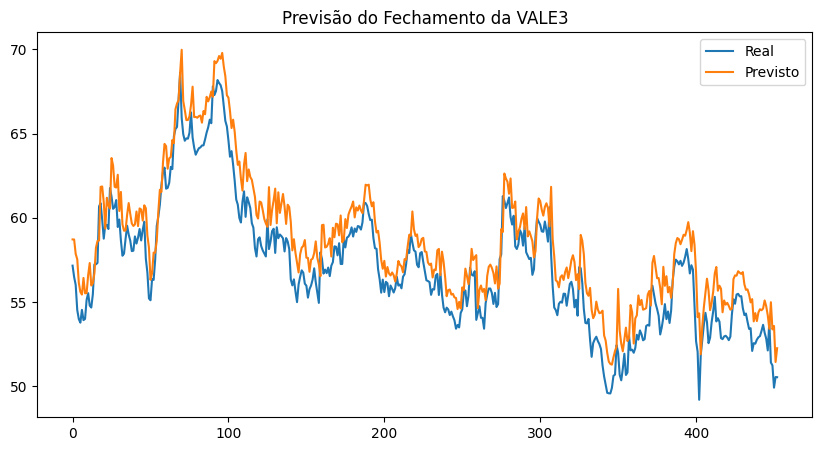

In [17]:
## 10. Gráfico

plt.figure(figsize=(10,5))
plt.plot(y_real, label='Real')
plt.plot(pred_real, label='Previsto')
plt.legend()
plt.title('Previsão do Fechamento da VALE3')
plt.show()

In [18]:
## 11. Tempo Final de Compilação
_end_time = time.time() - _start_time
print(f"Tempo total de execução: {_end_time:.2f} segundos")

Tempo total de execução: 6033.56 segundos
